| Name | ID |
| --- | --- |
| Ahmed Mostafa AbdEl-Rahman | 20221372883 |
| Mazen Gaber Mahmoud | 20221372110 |

# Import Libraries And Models

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import nltk
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, SimpleRNN, Dropout
from keras.callbacks import EarlyStopping
import numpy as np

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Loading The Dataset

In [2]:
data_path = "/kaggle/input/spam-classification-for-basic-nlp/Spam Email raw text for NLP.csv"
data = pd.read_csv(data_path)


# Text Preprocessing

In [3]:
stop_words = set(stopwords.words('english'))  # Set of common English stop words
ps = PorterStemmer()  # Initialize Porter Stemmer for word stemming

def preprocess_text(text):
    """
    Preprocesses the text data by removing HTML tags, tokenizing, removing stop words,
    and performing stemming on each word.

    Args:
    - text: Input text data to be preprocessed

    Returns:
    - clean_text: Processed and cleaned text data
    """
    # Remove HTML tags using regex
    clean_text = re.sub(r'<.*?>', '', text)
    
    # Tokenization
    tokens = word_tokenize(clean_text)
    
    # Removing stop words and stemming
    filtered_tokens = [ps.stem(word.lower()) for word in tokens if word.lower() not in stop_words and word.isalpha()]
    
    return ' '.join(filtered_tokens)

# Apply preprocessing function to 'MESSAGE' column in the dataset and store processed text in 'Processed_Message'
data['Processed_Message'] = data['MESSAGE'].apply(preprocess_text)

# Split data into features (X: Processed_Message) and target (y: CATEGORY)
X = data['Processed_Message']  # Features
y = data['CATEGORY']  # Target labels

# Data Preprocessing

In [4]:
# Split the data into training, validation, and testing sets using a 80-10-10 split
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.11, random_state=42)

# Vectorize the text data using CountVectorizer
vectorizer = CountVectorizer() # Initialize CountVectorizer for text vectorization
X_train_vectorized = vectorizer.fit_transform(X_train)  # Vectorize the training data
X_val_vectorized = vectorizer.transform(X_val) # Vectorize the validation data based on the training data's vocabulary
X_test_vectorized = vectorizer.transform(X_test) # Vectorize the testing data based on the training data's vocabulary

# Naive Bayes classifier

In [5]:
# Train Naive Bayes classifier
naive_bayes = MultinomialNB()  # Initialize a Multinomial Naive Bayes classifier
naive_bayes.fit(X_train_vectorized, y_train)  # Train the classifier using the vectorized training data

# Make predictions on the test set using the trained Naive Bayes classifier
nb_predictions = naive_bayes.predict(X_test_vectorized)  # Predict labels for the test set
nb_accuracy = accuracy_score(y_test, nb_predictions)  # Calculate the accuracy of the classifier
print("Naive Bayes Accuracy:", nb_accuracy)  # Print the accuracy of the Naive Bayes classifier

# Generate a detailed classification report for Logistic Regression
# This report includes precision, recall, F1-score, and support for each class
nb_report = classification_report(y_test, nb_predictions) # Calculate precision, recall, F1-score, and support
print("Naive Bayes Classification Report:")
print(nb_report)


Naive Bayes Accuracy: 0.9706896551724138
Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       376
           1       0.99      0.93      0.96       204

    accuracy                           0.97       580
   macro avg       0.98      0.96      0.97       580
weighted avg       0.97      0.97      0.97       580



# Logistic Regression classifier

In [6]:
# Train Logistic Regression classifier
logistic_regression = LogisticRegression()  # Initialize a Logistic Regression classifier
logistic_regression.fit(X_train_vectorized, y_train)  # Train the classifier using the vectorized training data

# Make predictions on the test set using the trained Logistic Regression classifier
lr_predictions = logistic_regression.predict(X_test_vectorized)  # Predict labels for the test set

# Calculate the accuracy of the Logistic Regression classifier
lr_accuracy = accuracy_score(y_test, lr_predictions)  # Calculate the accuracy

# Print Logistic Regression Accuracy
print("\nLogistic Regression Accuracy:", lr_accuracy)

# Print Logistic Regression Model report
lr_report = classification_report(y_test, lr_predictions)  
print("\nLogistic Regression Classification Report:")
print(lr_report)


Logistic Regression Accuracy: 0.9810344827586207

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       376
           1       0.97      0.98      0.97       204

    accuracy                           0.98       580
   macro avg       0.98      0.98      0.98       580
weighted avg       0.98      0.98      0.98       580



# Simple RNN Model

In [7]:
# Tokenize the text data for RNN models
max_words = 1000  # Maximum number of words to keep based on frequency
tokenizer = Tokenizer(num_words=max_words)  # Initialize Tokenizer with a maximum number of words
tokenizer.fit_on_texts(X_train)  # Fit tokenizer on training data to build word index
X_train_sequence = tokenizer.texts_to_sequences(X_train)  # Convert text sequences to numerical sequences
X_val_sequence = tokenizer.texts_to_sequences(X_val)    # Convert validation text sequences to numerical sequences
X_test_sequence = tokenizer.texts_to_sequences(X_test)  # Convert test text sequences to numerical sequences

# Pad sequences for RNN models to ensure uniform length
max_len = 150  # Maximum length of sequences
X_train_pad = pad_sequences(X_train_sequence, maxlen=max_len)  # Pad training sequences to a fixed length
X_val_pad = pad_sequences(X_val_sequence, maxlen=max_len)    # Pad validation sequences to a fixed length
X_test_pad = pad_sequences(X_test_sequence, maxlen=max_len)  # Pad test sequences to a fixed length


In [8]:
# Add early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Build Simple RNN model
rnn_model = Sequential()  # Initialize a Sequential model
rnn_model.add(Embedding(max_words, 50, input_length=max_len))  # Add an Embedding layer for word embeddings
rnn_model.add(SimpleRNN(50))  # Add a Simple RNN layer with 50 units
rnn_model.add(Dropout(0.5))  # Add dropout layer
rnn_model.add(Dense(1, activation='sigmoid'))  # Add a Dense layer with sigmoid activation for binary classification
rnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])  # Compile the model
rnn_model.fit(X_train_pad, y_train, epochs=5, batch_size=32, validation_data=(X_val_pad, y_val), callbacks=[early_stopping])  # Train the model

# Predict using the trained RNN model on the test data and calculate accuracy
rnn_predictions = np.round(rnn_model.predict(X_test_pad)).astype(int).flatten()  # Make predictions
rnn_accuracy = accuracy_score(y_test, rnn_predictions)  # Calculate accuracy
print("\nSimple RNN Accuracy:", rnn_accuracy)  # Print Simple RNN accuracy

# Print Simple RNN Model Summary showing model architecture and parameters
print("\nSimple RNN Model Summary:")
print(rnn_model.summary())

Epoch 1/5
146/146 [==============================] - 45s 270ms/step - loss: 0.4146 - accuracy: 0.8132 - val_loss: 0.1371 - val_accuracy: 0.9599
Epoch 2/5
146/146 [==============================] - 29s 195ms/step - loss: 0.0879 - accuracy: 0.9774 - val_loss: 0.0764 - val_accuracy: 0.9721
Epoch 3/5
146/146 [==============================] - 23s 159ms/step - loss: 0.0505 - accuracy: 0.9882 - val_loss: 0.0473 - val_accuracy: 0.9808
Epoch 4/5
146/146 [==============================] - 22s 151ms/step - loss: 0.0406 - accuracy: 0.9899 - val_loss: 0.0522 - val_accuracy: 0.9808
Epoch 5/5
19/19 [==============================] - 1s 12ms/step

Simple RNN Accuracy: 0.9793103448275862

Simple RNN Model Summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 50)           50000     
                                                                 
 simple_

# LSTM Model

In [9]:
# Build LSTM model
lstm_model = Sequential()  # Initialize a Sequential model
lstm_model.add(Embedding(max_words, 50, input_length=max_len))  # Add an Embedding layer for word embeddings
lstm_model.add(LSTM(50))  # Add an LSTM layer with 50 units
lstm_model.add(Dropout(0.5))  # Add dropout layer
lstm_model.add(Dense(1, activation='sigmoid'))  # Add a Dense layer with sigmoid activation for binary classification
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])  # Compile the model
lstm_model.fit(X_train_pad, y_train, epochs=5, batch_size=32, validation_data=(X_val_pad, y_val), callbacks=[early_stopping])  # Train the model

# Predict using the trained LSTM model on the test data and calculate accuracy
lstm_predictions = np.round(lstm_model.predict(X_test_pad)).astype(int).flatten()  # Make predictions
lstm_accuracy = accuracy_score(y_test, lstm_predictions)  # Calculate accuracy
print("\nLSTM Accuracy:", lstm_accuracy)  # Print LSTM accuracy

# Print LSTM Model Summary showing model architecture and parameters
print("\nLSTM Model Summary:")
print(lstm_model.summary())

Epoch 1/5
146/146 [==============================] - 20s 117ms/step - loss: 0.2786 - accuracy: 0.8763 - val_loss: 1.3337 - val_accuracy: 0.6725
Epoch 2/5
146/146 [==============================] - 7s 52ms/step - loss: 0.1195 - accuracy: 0.9582 - val_loss: 0.0612 - val_accuracy: 0.9739
Epoch 3/5
146/146 [==============================] - 6s 39ms/step - loss: 0.0750 - accuracy: 0.9739 - val_loss: 0.1015 - val_accuracy: 0.9669
Epoch 4/5
146/146 [==============================] - 5s 32ms/step - loss: 0.0666 - accuracy: 0.9741 - val_loss: 0.0476 - val_accuracy: 0.9774
Epoch 5/5
19/19 [==============================] - 0s 3ms/step

LSTM Accuracy: 0.9672413793103448

LSTM Model Summary:
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 150, 50)           50000     
                                                                 
 lstm (LSTM)             

# Models Comparison

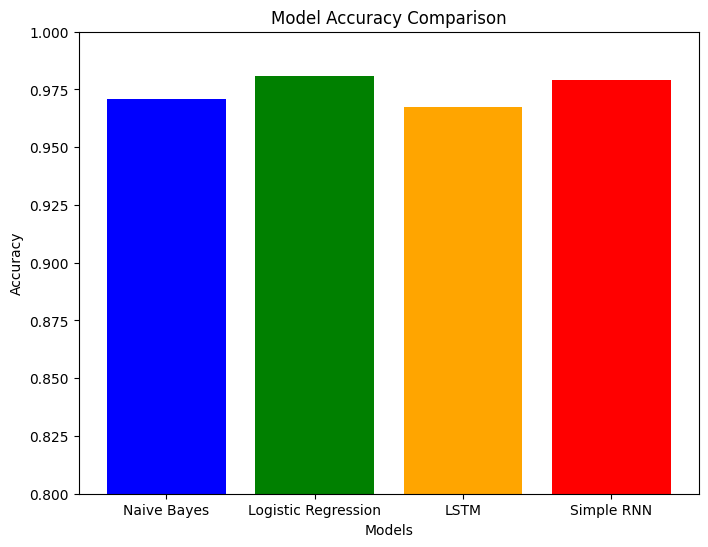

In [10]:
# List of model names and their corresponding accuracies
model_names = ['Naive Bayes', 'Logistic Regression', 'LSTM', 'Simple RNN']
accuracies = [nb_accuracy, lr_accuracy, lstm_accuracy, rnn_accuracy]

# Create a bar plot to compare the accuracies of different models
plt.figure(figsize=(8, 6))  # Set the figure size for the plot
plt.bar(model_names, accuracies, color=['blue', 'green', 'orange', 'red'])  # Plot the bar chart
plt.title('Model Accuracy Comparison')  # Set the title of the plot
plt.xlabel('Models')  # Set the label for the x-axis
plt.ylabel('Accuracy')  # Set the label for the y-axis
plt.ylim(0.8, 1.0)  # Set the y-axis limits to show accuracies between 0.8 and 1.0
plt.show()  # Display the plot


# Examples

In [11]:
# Load three example messages
examples = [
    "Congratulations! You've won a free vacation. Click here to claim your prize." ,
    "Hi,I am Ahmed."
]

# Preprocess the examples
processed_examples = [preprocess_text(example) for example in examples]

# Function to map binary predictions to 'spam' or 'not spam'
def map_to_label(prediction):
    return 'spam' if prediction == 1 else 'not spam'

# Get predictions from all models for the examples with 'spam' or 'not spam' labels
for i, example in enumerate(processed_examples, start=1):
    print(f"\nExample {i}: {examples[i-1]}")
    
    # Naive Bayes Prediction
    nb_pred = map_to_label(naive_bayes.predict(vectorizer.transform([example]))[0])
    print("Naive Bayes Prediction:", nb_pred)
    
    # Logistic Regression Prediction
    lr_pred = map_to_label(logistic_regression.predict(vectorizer.transform([example]))[0])
    print("Logistic Regression Prediction:", lr_pred)
    
    # LSTM Prediction
    lstm_pred = map_to_label(np.round(lstm_model.predict(pad_sequences(tokenizer.texts_to_sequences([example]), maxlen=max_len)))[0][0])
    print("LSTM Prediction:", lstm_pred)
    
    # Simple RNN Prediction
    rnn_pred = map_to_label(np.round(rnn_model.predict(pad_sequences(tokenizer.texts_to_sequences([example]), maxlen=max_len)))[0][0])
    print("Simple RNN Prediction:", rnn_pred)



Example 1: Congratulations! You've won a free vacation. Click here to claim your prize.
Naive Bayes Prediction: spam
Logistic Regression Prediction: spam
1/1 [==============================] - 0s 22ms/step
LSTM Prediction: spam
1/1 [==============================] - 0s 30ms/step
Simple RNN Prediction: spam

Example 2: Hi,I am Ahmed.
Naive Bayes Prediction: not spam
Logistic Regression Prediction: spam
1/1 [==============================] - 0s 23ms/step
LSTM Prediction: not spam
1/1 [==============================] - 0s 30ms/step
Simple RNN Prediction: spam
